In [1]:
#|default_exp init

# Initialisation and Normalisation
In this notebook, our goal is to get as close to 90% accuracy as possible on the Fashion MNIST dataset simply by changing how we initialise the weights/biases and normalising the inputs/layers etc.

There will be no change to our model architecture.

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

We are going to repeat the steps that we took in our previous notebook- define a simple CNN and see our performance on the Fashion MNIST dataset.

In [5]:
def get_model():
    return nn.Sequential(conv(1, 8), conv(8, 16), conv(16, 32), conv(32, 64),
                         conv(64, 10, act=False), nn.Flatten()).to(def_device)

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


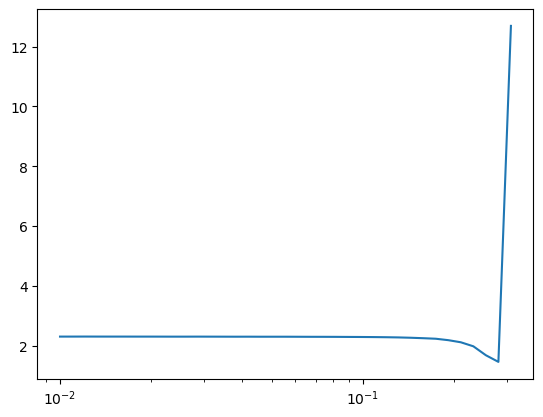

In [7]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [10]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.171,0.000,0,train
0.100,0.000,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

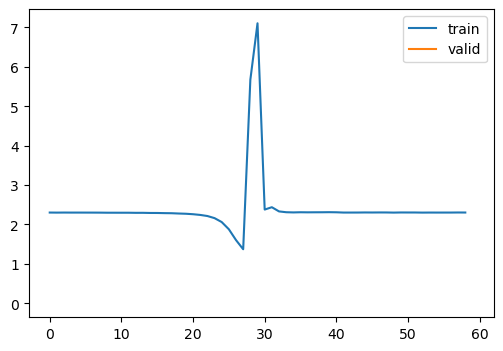

In [11]:
learn.fit(1)

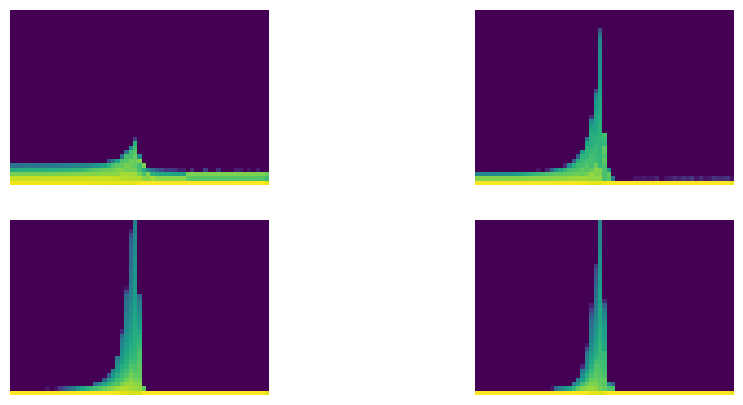

In [12]:
astats.color_dim()

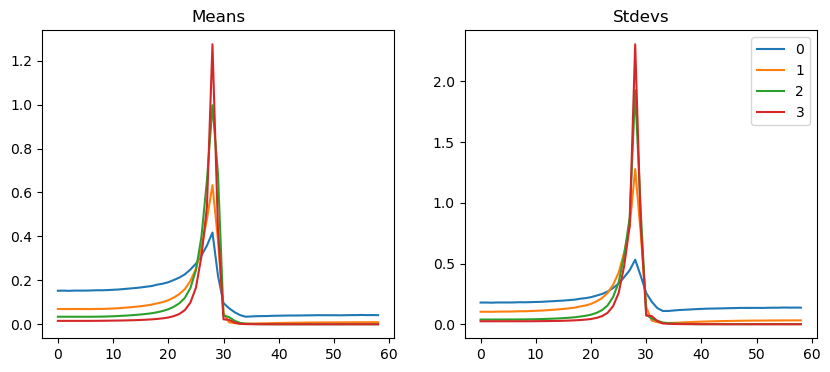

In [13]:
astats.plot_stats()

We see that our model did not really learn anything significant. This is mainly so because as we learnt from our last lesson, most of our activations are actually zero.

Before we proceed to setting up initialisation of the inputs, there are a couple of helper functions that will be helpful to discuss:
1. `clean_ipython_hist`. It turns out that in Jupyter notebook, previous calculations are stored in memory (cached). This is troublesome if we had a large tensor stored on the GPU in our previous calculations. `clean_ipython_hist` helps us to solve this problem.
2. `clean_tb`. Similar to the problem above, it turns out that if we have a failed computation, variables on that traceback may not be deleted properly. 

In [14]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [15]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [16]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier init
Previously, we do not care about initialising our weights/biases. However, we know that ideally we want activations of mean 0 and standard deviation 1. Let's see what happens when we randomly create an input tensor `x` that is normally distributed, and pass it through 50 layers that are normally distributed as well.

In [18]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100)
x[:5, :5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

We see that we get all `nan` in our example. What happened? It turns out that when we have a deep neural network with weights and biases of normal distribution, our output at the end is very large. Is the solution to scale the weights to a smaller one instead?

In [20]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100) * 0.01
x[:5, :5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

As we can see, using overly small weights and biases lead to zero outputs as well. So we need to scale our weights and biases just right. We can use the Glorot/Xavier initialisation technique.

While the Glorot Xavier paper calls for a uniform distribution for weights, we take a shortcut and just scale our weights by the suggested value of $\frac{1}{\sqrt{n_{in}}}$, where $n_{in}$ is the dimension of the previous layer.

In [22]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100) * (1 / math.sqrt(100))
x[:5, :5]

tensor([[-0.68, -0.57, -1.01,  0.49,  0.21],
        [ 0.13,  0.79, -1.80, -0.29,  0.65],
        [ 0.61,  2.04, -0.45,  0.70,  0.38],
        [ 0.61,  1.07,  0.75,  0.40, -0.46],
        [-0.54, -2.05,  0.06, -0.85,  0.41]])

This looks much better!

## Kaiming/He init
While Glorot Xavier initialisation works for our example above, we have neglected the fact that we use ReLU as an activation function. Now what happens to our activation's mean and variance when we use ReLU? Let's find out.

In [25]:
x = torch.randn(200, 100)
w1 = torch.randn(100, 100) * (1 / math.sqrt(100))
b1 = torch.zeros(100)

In [26]:
out = x @ w1 + b1
out.mean(), out.std()

(tensor(-0.01), tensor(1.01))

This is our previous example of not using ReLU. Now let's pass our output through ReLU.

In [28]:
relu_out = out.clamp(min=0)
relu_out.mean(), relu_out.std()

(tensor(0.40), tensor(0.59))

We see that our mean is not 0, and neither is our variance 1 anymore. This is where Kaiming/He initialisation comes in. He's initialisation maintains that the mean should be 0. However, the variance should be $\frac{2}{n_{in}}$.

Let's try applying this and see what happens.

In [29]:
x = torch.randn(200, 100)
w1 = torch.randn(100, 100) * (2 / math.sqrt(100))
b1 = torch.zeros(100)

relu_out = (x@w1 + b1).clamp(min=0)
relu_out.mean(), relu_out.std()

(tensor(0.80), tensor(1.16))

This seems slightly better than our mean/variance from Glorot/Xavier above. Better to test a 'deep' neural net to see what happens.

In [36]:
x = torch.randn(200, 100)
for i in range(50): x = (x @ (torch.randn(100, 100) * math.sqrt(1/100))).clamp(min=0) 
x[:5, :5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [38]:
x = torch.randn(200, 100)
for i in range(50): x = (x @ (torch.randn(100, 100) * math.sqrt(2/100))).clamp(min=0) 
x[:5, :5]

tensor([[0.00, 2.63, 0.00, 0.00, 1.87],
        [0.00, 1.67, 0.00, 0.00, 1.04],
        [0.00, 1.69, 0.00, 0.00, 0.90],
        [0.00, 2.92, 0.00, 0.00, 2.00],
        [0.00, 1.51, 0.00, 0.00, 0.89]])

We see that more activations are preserved after 50 iterations using He's initialisation.